# Imports

In [173]:
%load_ext autoreload
%autoreload 2

#import viewdat_cno_lib as vdl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import geopy.distance
import datetime
import time
import os
import subprocess
import math
#import glob
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [212]:
def combine_T04(hourly_dir, out_name):
    if os.path.isfile(out_name):
        print(f'{out_name} already exists.. deleting it')
        os.remove(out_name)

    #print(f"   combine({fname_base}, {out_name})")
    # List of files to concat
    flist = sorted(glob.glob('*T04', root_dir=os.path.join(hourly_dir)))

    with open(out_name, 'wb') as wfd:
        for f in flist:
            f_path = os.path.join(hourly_dir, f)
            print(f"    appending {f} to {out_name}")
            with open(f_path, 'rb') as fd:
                shutil.copyfileobj(fd, wfd)

In [2]:
def pos_read(fname_tsv, header_n_rows=159):
    if not os.path.isfile(fname_tsv):
        print(f"Unable to find {fname_tsv}")
        return None
    # Import the data into a Pandas DataFrame, and do some cleanup
    df = pd.read_csv(fname_tsv, delimiter='\t', header=header_n_rows, na_values=['Nan'])
    df.rename(columns=lambda x: x.strip(), inplace=True)  # drop whitespace
    df = df.replace({'Nan': np.nan})
    #print(list(df.columns))
    cols_rename = {
        '%Week': 'Week',
        # 'TRACK': 'Track',
    }
    df.rename(columns=cols_rename, inplace=True)
    #df = week_rollover_unwrap(df)
    return df

In [3]:
# This class was brazenly stolen from mutils.py in the Sunnyvale CVS repo
class OrbitConst(object):
    """
    Orbital constants
    """
    PI = 3.14159265358979323846
    A_WGS84 = 6378137.0
    B_WGS84 = 6356752.314245179
    E2_WGS84 = 6.69437999013e-3
    ONE_MIN_E2 = 0.99330562000987
    SQRT_ONE_MIN_E2 = 9.96647189335258e-1
    

# This function was brazenly stolen from mutils.py in the Sunnyvale CVS repo
def llh2enu(llh, ref_llh, is_rad=False, is_ref_rad=False):
    """
    Convert lat/lon/height to delta east/north/up.
    llh = array of lat/lon/height [lat/lon in degrees by default]
    ref_llh = point or array of lat/lon/height [lat/lon in degrees by default]
    is_rad = True -> "llh" lat/lon is radians, else in degrees
    is_ref_rad = True -> "ref_llh" lat/lon is radians, else in degrees
    """
    # Make sure inputs are arrays
    if len(np.shape(llh)) == 1:
        llh = llh.reshape((1, len(llh)))
    if len(np.shape(ref_llh)) == 1:
        ref_llh = ref_llh.reshape((1, len(ref_llh)))

    # Convert to radians?
    scale1 = np.ones(np.shape(llh))
    scale2 = np.ones(np.shape(ref_llh))
    ref_lat = np.copy(ref_llh[:, 0])
    if not is_rad:
        scale1[:, 0:2] *= OrbitConst.PI/180
    if not is_ref_rad:
        scale2[:, 0:2] *= OrbitConst.PI/180
        ref_lat *= OrbitConst.PI/180

    # Compute the residuals
    dllh = llh*scale1 - ref_llh*scale2

    # Compute Radii of Curvature
    W = np.sqrt(1 - OrbitConst.E2_WGS84 * np.sin(ref_lat)**2)
    N = OrbitConst.A_WGS84 / W
    M = OrbitConst.A_WGS84 * (1 - OrbitConst.E2_WGS84) / W**3

    # Compute Metric Components
    dE = dllh[:, 1] * N * np.cos(ref_lat)
    dN = dllh[:, 0] * M
    dU = dllh[:, 2]

    return (dE, dN, dU)

In [4]:
def calc_heading(lat1, long1, lat2, long2):
    rlat1 = math.radians(lat1)
    rlat2 = math.radians(lat2)
    rlon1 = math.radians(long1)
    rlon2 = math.radians(long2)
    dLon = rlon2 - rlon1
    x = math.cos(rlat2) * math.sin(dLon)
    y = math.cos(rlat1) * math.sin(rlat2)
    y -= math.sin(rlat1) * math.cos(rlat2) * math.cos(dLon)
    heading = np.arctan2(x, y)
    heading = math.degrees(heading)
    heading = (heading + 180.0) % 360.0   # convert from -180:+180 to 0:360
    return heading

In [189]:
from datetime import datetime, timedelta
import pytz

def gps_datetime(time_week, time_ms, leap_seconds=37):
    # 37 leap seconds seems to be correct for 2016-12-31 through at least 2023
    gps_epoch = datetime(1980, 1, 6, tzinfo=pytz.utc)
    # gps_time - utc_time = leap_seconds
    return gps_epoch + timedelta(weeks=time_week, milliseconds=time_ms, seconds=-leap_seconds)

print(gps_datetime(2292, 266792379))
print(gps_datetime(2319, 500177.0*1000))

2023-12-13 02:05:55.379000+00:00
2024-06-21 18:55:40+00:00


In [118]:
def delta_enu_start(df):
    df[['dN', 'dE', 'dH']] = df[['N', 'E', 'Ele']] - df.iloc[0][['N', 'E', 'Ele']]
    return df

In [156]:
def delta_pos_start(df):
    start = df.iloc[0]
    start_pt = np.array([start.MLat, start.MLon, start.MHgt])
    #print(f'start_pt: {start_pt}')
    llh = np.array(df[['MLat', 'MLon', 'MHgt']])
    #print('llh:')
    #print(llh)
    a = np.array(llh2enu(llh, start_pt))
    #print('a:')
    #display(a)
    #print(a.shape)
    #print(df.shape)
    df[['dN', 'dE', 'dH']] = a.transpose()
    return df

In [5]:
def dms_to_dd(d:float, m:float, s:float):
    dd = d + float(m)/60 + float(s)/3600
    if d<0:
        dd = float(d) - float(m)/60 - float(s)/3600
    else:
        dd = float(d) + float(m)/60 + float(s)/3600
    return dd

In [222]:
def import_t04_dir(dir_name, fname_base):
    fname_T04 = f'{fname_base}.T04'
    fname_tsv = f'{fname_base}_pos.tsv'

    combine_T04(dir_name, fname_T04)
    cmd = f'viewdat -d35:2 --t04_vector_position -mb -h {fname_T04} -o{fname_tsv}'.replace(' ', ',').split(',')
    print(f'{cmd=}')
    subprocess.run(cmd)
    df = pos_read(fname_tsv, 159) #102)
    df = df[['Week', 'Time', 'RefSys', 
             'MFixMode', 'MFixType', 'MFixInfo', 
             'MLat', 'MLon', 'MHgt', 'MSigN', 'MSigE', 'MSigU', 'MSigEN', 'MSigEU', 'MSigNU', 
             'RefLat', 'RefLon', 'RefHgt', 
             'VLat', 'VLon', 'VHgt', 'VSigN', 'VSigE', 'VSigU', 'VSigEN', 'VSigEU', 'VSigNU', 
             'corrAge']]
    df = delta_pos_start(df)
    df['time_utc'] = df.apply(lambda x: gps_datetime(time_week = x['Week'], time_ms = x['Time']*1000), axis=1)
    return df

# Viewdat (Judo, R780)

In [223]:
df_judo = import_t04_dir('Judo_EB93', 'judo')
display(df_judo)

judo.T04 already exists.. deleting it
    appending EB1-5093__202406211845.T04 to judo.T04
    appending EB1-5093__202406211900.T04 to judo.T04
    appending EB1-5093__202406211915.T04 to judo.T04
    appending EB1-5093__202406211930.T04 to judo.T04
    appending EB1-5093__202406211945.T04 to judo.T04
    appending EB1-5093__202406212000.T04 to judo.T04
    appending EB1-5093__202406212015.T04 to judo.T04
    appending EB1-5093__202406212030.T04 to judo.T04
cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', 'judo.T04', '-ojudo_pos.tsv']


Week      Time  RefSys  MFixMode  MFixType  MFixInfo       MLat  \
0      2319  500177.0       0         5         4         0  39.895810   
1      2319  500177.2       0         5         4         0  39.895810   
2      2319  500177.3       0         5         4         0  39.895810   
3      2319  500177.4       0         5         4         0  39.895810   
4      2319  500177.5       0         5         4         0  39.895810   
...     ...       ...     ...       ...       ...       ...        ...   
64824  2319  506699.1       0         5         4         0  39.895883   
64825  2319  506699.2       0         5         4         0  39.895883   
64826  2319  506699.3       0         5         4         0  39.895883   
64827  2319  506699.4       0         5         4         0  39.895883   
64828  2319  506699.5       0         5         4         0  39.895883   

             MLon       MHgt   MSigN  ...   VSigE   VSigU  VSigEN  VSigEU  \
0     -105.112955  1645.6199  0.0095  ...  0.0023  0.0027  0.0009 -0.0009   
1     -105.112955  1645.6199  0.0095  ...  0.0022  0.0026  0.0010 -0.0008   
2     -105.112955  1645.6191  0.0096  ...  0.0022  0.0026  0.0010 -0.0008   
3     -105.112955  1645.6187  0.0097  ...  0.0022  0.0026  0.0010 -0.0008   
4     -105.112955  1645.6177  0.0097  ...  0.0022  0.0026  0.0010 -0.0008   
...           ...        ...     ...  ...     ...     ...     ...     ...   
64824 -105.113186  1646.0046  0.0051  ...  0.0023  0.0023  0.0006 -0.0005   
64825 -105.113186  1646.0042  0.0051  ...  0.0023  0.0023  0.0005 -0.0005   
64826 -105.113186  1646.0044  0.0053  ...  0.0023  0.0023  0.0005 -0.0005   
64827 -105.113186  1646.0039  0.0053  ...  0.0023  0.0023  0.0005 -0.0005   
64828 -105.113186  1646.0042  0.0054  ...  0.0023  0.0023  0.0005 -0.0005   

       VSigNU  corrAge         dN        dE      dH  \
0     -0.0011      1.0   0.000000  0.000000  0.0000   
1     -0.0011      1.2  -0.000932  0.000133  0.0000   
2     -0.0011      1.3   0.000496  0.001665 -0.0008   
3     -0.0011      1.4   0.000043  0.001677 -0.0012   
4     -0.0011      1.5  -0.000342  0.001343 -0.0022   
...       ...      ...        ...       ...     ...   
64824 -0.0006      2.1 -19.719607  8.163508  0.3847   
64825 -0.0007      2.2 -19.718863  8.163175  0.3843   
64826 -0.0007      2.3 -19.719248  8.164329  0.3845   
64827 -0.0007      2.4 -19.719684  8.163941  0.3840   
64828 -0.0007      2.5 -19.719564  8.162830  0.3843   

                              time_utc  
0            2024-06-21 18:55:40+00:00  
1     2024-06-21 18:55:40.200000+00:00  
2     2024-06-21 18:55:40.300000+00:00  
3     2024-06-21 18:55:40.400000+00:00  
4     2024-06-21 18:55:40.500000+00:00  
...                                ...  
64824 2024-06-21 20:44:22.100000+00:00  
64825 2024-06-21 20:44:22.200000+00:00  
64826 2024-06-21 20:44:22.300000+00:00  
64827 2024-06-21 20:44:22.400000+00:00  
64828 2024-06-21 20:44:22.500000+00:00  

[64829 rows x 32 columns]

In [224]:
df_r780= import_t04_dir('R780', 'r780')
display(df_r780)

r780.T04 already exists.. deleting it
    appending Trimble___202406211845.T04 to r780.T04
    appending Trimble___202406211900.T04 to r780.T04
    appending Trimble___202406211915.T04 to r780.T04
    appending Trimble___202406211930.T04 to r780.T04
    appending Trimble___202406211945.T04 to r780.T04
    appending Trimble___202406212000.T04 to r780.T04
    appending Trimble___202406212015.T04 to r780.T04
    appending Trimble___202406212030.T04 to r780.T04
    appending Trimble___202406212045.T04 to r780.T04
cmd=['viewdat', '-d35:2', '--t04_vector_position', '-mb', '-h', 'r780.T04', '-or780_pos.tsv']


Week      Time  RefSys  MFixMode  MFixType  MFixInfo       MLat  \
0      2319  499500.1       0         5        20         0  39.895813   
1      2319  499500.2       0         5        20         0  39.895813   
2      2319  499500.3       0         5        20         0  39.895813   
3      2319  499500.4       0         5        20         0  39.895813   
4      2319  499500.5       0         5        20         0  39.895813   
...     ...       ...     ...       ...       ...       ...        ...   
71624  2319  506762.4       0         5        20         0  39.895885   
71625  2319  506762.5       0         5        20         0  39.895885   
71626  2319  506762.6       0         5        20         0  39.895885   
71627  2319  506762.7       0         5        20         0  39.895885   
71628  2319  506762.8       0         5        20         0  39.895885   

             MLon       MHgt   MSigN  ...  VSigE  VSigU  VSigEN  VSigEU  \
0     -105.112953  1645.6958  0.0064  ...    NaN    NaN     NaN     NaN   
1     -105.112953  1645.6965  0.0063  ...    NaN    NaN     NaN     NaN   
2     -105.112953  1645.6968  0.0063  ...    NaN    NaN     NaN     NaN   
3     -105.112953  1645.6968  0.0063  ...    NaN    NaN     NaN     NaN   
4     -105.112953  1645.6970  0.0063  ...    NaN    NaN     NaN     NaN   
...           ...        ...     ...  ...    ...    ...     ...     ...   
71624 -105.113183  1646.0945  0.0047  ...    NaN    NaN     NaN     NaN   
71625 -105.113183  1646.0942  0.0047  ...    NaN    NaN     NaN     NaN   
71626 -105.113183  1646.0942  0.0047  ...    NaN    NaN     NaN     NaN   
71627 -105.113183  1646.0940  0.0047  ...    NaN    NaN     NaN     NaN   
71628 -105.113183  1646.0938  0.0047  ...    NaN    NaN     NaN     NaN   

       VSigNU  corrAge         dN        dE      dH  \
0         NaN      1.0   0.000000  0.000000  0.0000   
1         NaN      1.0  -0.002138 -0.005863  0.0007   
2         NaN      1.0  -0.001933 -0.006118  0.0010   
3         NaN      1.0  -0.001736 -0.006362  0.0010   
4         NaN      1.0  -0.001531 -0.006618  0.0012   
...       ...      ...        ...       ...     ...   
71624     NaN      1.0 -19.620998  7.969134  0.3987   
71625     NaN      1.0 -19.621074  7.968590  0.3984   
71626     NaN      1.0 -19.621151  7.968024  0.3984   
71627     NaN      1.0 -19.621237  7.967457  0.3982   
71628     NaN      1.0 -19.621331  7.966880  0.3980   

                              time_utc  
0     2024-06-21 18:44:23.100000+00:00  
1     2024-06-21 18:44:23.200000+00:00  
2     2024-06-21 18:44:23.300000+00:00  
3     2024-06-21 18:44:23.400000+00:00  
4     2024-06-21 18:44:23.500000+00:00  
...                                ...  
71624 2024-06-21 20:45:25.400000+00:00  
71625 2024-06-21 20:45:25.500000+00:00  
71626 2024-06-21 20:45:25.600000+00:00  
71627 2024-06-21 20:45:25.700000+00:00  
71628 2024-06-21 20:45:25.800000+00:00  

[71629 rows x 32 columns]

Judo UTC: 2024-06-21 18:55:40+00:00 2024-06-21 20:44:22.500000+00:00
R780 UTC: 2024-06-21 18:44:23.100000+00:00 2024-06-21 20:45:25.800000+00:00
64829


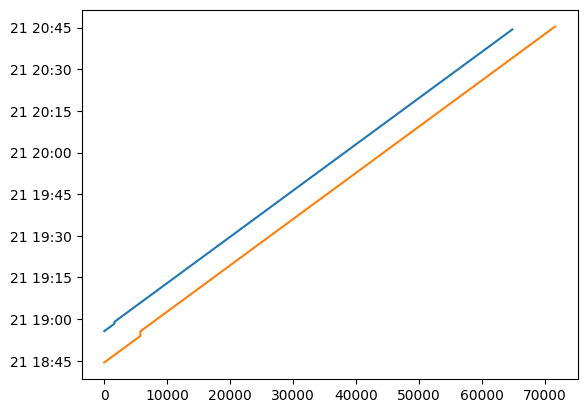

In [225]:
judo_N = df_judo.shape[0] -1
print('Judo UTC:', df_judo.time_utc[0],  df_judo.time_utc[judo_N]) #, df_judo.time_utc[judo_N] - df_judo.time_utc[0])
r780_N = df_r780.shape[0] -1
print('R780 UTC:', df_r780.time_utc[0],  df_r780.time_utc[r780_N]) #, df_r780.time_utc[r780_N] - df_r780.time_utc[0])
plt.plot(df_judo.time_utc)
plt.plot(df_r780.time_utc)
print(df_judo.shape[0])
#print(df_judo.time_utc[1800:1805])
#print(df_72310017.t[0:5])

# ATS

In [124]:
count = 0
header = None
mylist =[]
with open("ATSTest_LogFile JUDO IN LINE and PERP.txt") as file:
    for line in file:
        if line.startswith('ATSDataEvent'):
            line = line.strip()
            #print(line)
            if header is None:
                header = line.split("\t")
                #print(header)
                #print("")
            else:
                d = dict(zip(header, line.split("\t")))
                mylist.append(d)
                #if count < 3:
                #    print(line.split("\t"))
                #    print("")

            count += 1
            #if count > 10:
            #    break

df_ats = pd.DataFrame(mylist)
df_ats = df_ats.drop(columns=['ATSDataEvent'])

df_ats = df_ats.astype({
    'SerialNumber': 'int',
    'N': 'float',
    'E': 'float',
    'Ele': 'float',
})
df_ats['t'] = pd.to_datetime(df_ats['Date'] + ' ' + df_ats['PCClock'], utc=True)
df_ats.t = df_ats.t + pd.Timedelta('06:00:00')
display(df_ats[['Date', 'Time', 'PCClock', 't']])
#display(df_ats.info())

#
# Split out the two MT Targets
#
df_72613087 = df_ats.query("SerialNumber==72613087")[['t', 'Date', 'Time', 'SerialNumber', 'PCTics', 'PCClock', 'S6TimeStamp',  'N', 'E', 'Ele']]
df_72613087 = df_72613087[df_72613087.N != 0]

df_72310017 = df_ats.query("SerialNumber==72310017")[['t', 'Date', 'Time', 'SerialNumber', 'PCTics', 'PCClock', 'S6TimeStamp',  'N', 'E', 'Ele']]
df_72310017 = df_72310017[df_72310017.N != 0]

df_72310017 = delta_enu_start(df_72310017)
df_72613087 = delta_enu_start(df_72613087)

display(df_72310017)

Date          Time       PCClock                                t
0       6/21/2024  13:04:03.638  13:04:03.545 2024-06-21 19:04:03.545000+00:00
1       6/21/2024  13:04:03.639  13:04:03.550 2024-06-21 19:04:03.550000+00:00
2       6/21/2024  13:04:03.640  13:04:03.591 2024-06-21 19:04:03.591000+00:00
3       6/21/2024  13:04:03.641  13:04:03.598 2024-06-21 19:04:03.598000+00:00
4       6/21/2024  13:04:03.722  13:04:03.644 2024-06-21 19:04:03.644000+00:00
...           ...           ...           ...                              ...
231136  6/21/2024  14:42:22.431  14:42:22.402 2024-06-21 20:42:22.402000+00:00
231137  6/21/2024  14:42:22.516  14:42:22.451 2024-06-21 20:42:22.451000+00:00
231138  6/21/2024  14:42:22.517  14:42:22.503 2024-06-21 20:42:22.503000+00:00
231139  6/21/2024  14:42:22.593  14:42:22.553 2024-06-21 20:42:22.553000+00:00
231140  6/21/2024  14:42:24.442  14:42:22.602 2024-06-21 20:42:22.602000+00:00

[231141 rows x 4 columns]

t       Date          Time  \
1      2024-06-21 19:04:03.550000+00:00  6/21/2024  13:04:03.639   
3      2024-06-21 19:04:03.598000+00:00  6/21/2024  13:04:03.641   
5      2024-06-21 19:04:03.650000+00:00  6/21/2024  13:04:03.723   
7      2024-06-21 19:04:03.698000+00:00  6/21/2024  13:04:03.724   
9      2024-06-21 19:04:03.749000+00:00  6/21/2024  13:04:03.801   
...                                 ...        ...           ...   
231083 2024-06-21 20:42:19.985000+00:00  6/21/2024  14:42:20.015   
231085 2024-06-21 20:42:20.037000+00:00  6/21/2024  14:42:20.090   
231087 2024-06-21 20:42:20.089000+00:00  6/21/2024  14:42:20.094   
231089 2024-06-21 20:42:20.136000+00:00  6/21/2024  14:42:22.031   
231091 2024-06-21 20:42:20.186000+00:00  6/21/2024  14:42:22.033   

        SerialNumber     PCTics       PCClock S6TimeStamp             N  \
1           72310017  607240031  13:04:03.550      518822  533832.73293   
3           72310017  607240078  13:04:03.598      518872  533832.73303   
5           72310017  607240125  13:04:03.650      518922  533832.73311   
7           72310017  607240171  13:04:03.698      518972  533832.73283   
9           72310017  607240218  13:04:03.749      519022  533832.73264   
...              ...        ...           ...         ...           ...   
231083      72310017  613136421  14:42:19.985     1860473  533840.56703   
231085      72310017  613136484  14:42:20.037     1860523  533840.56722   
231087      72310017  613136531  14:42:20.089     1860573  533840.56701   
231089      72310017  613136578  14:42:20.136     1860623  533840.56689   
231091      72310017  613136625  14:42:20.186     1860673  533840.56729   

                   E         Ele       dN        dE       dH  
1       947504.49197  1645.84958      0.0       0.0      0.0  
3       947504.49142  1645.84957   0.0001  -0.00055 -0.00001  
5       947504.49160  1645.84962  0.00018  -0.00037  0.00004  
7       947504.49195  1645.84963  -0.0001  -0.00002  0.00005  
9       947504.49201  1645.84958 -0.00029   0.00004      0.0  
...              ...         ...      ...       ...      ...  
231083  947484.91579  1646.24738   7.8341 -19.57618   0.3978  
231085  947484.91548  1646.24731  7.83429 -19.57649  0.39773  
231087  947484.91582  1646.24733  7.83408 -19.57615  0.39775  
231089  947484.91604  1646.24731  7.83396 -19.57593  0.39773  
231091  947484.91546  1646.24724  7.83436 -19.57651  0.39766  

[97479 rows x 13 columns]

(array([1.5303e+04, 2.1294e+04, 2.1080e+04, 6.9290e+03, 5.2010e+03,
        6.9640e+03, 6.8390e+03, 1.3614e+04, 3.7250e+03, 6.0000e+00]),
 array([0.    , 0.0062, 0.0124, 0.0186, 0.0248, 0.031 , 0.0372, 0.0434,
        0.0496, 0.0558, 0.062 ]),
 <BarContainer object of 10 artists>)

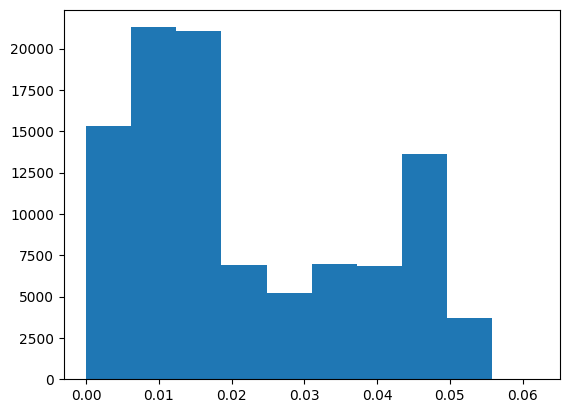

In [116]:
df_72613087['delta'] = df_ats.t.diff().dt.total_seconds()
#display(df_72613087)
#print("")
#print(df_72613087.delta.mean())
plt.hist(df_72613087.delta)

(array([10403.,  7014.,  4372.,  4523.,  6069.,  6294., 21091., 19389.,
        14949.,  3375.]),
 array([-0.001 ,  0.0045,  0.01  ,  0.0155,  0.021 ,  0.0265,  0.032 ,
         0.0375,  0.043 ,  0.0485,  0.054 ]),
 <BarContainer object of 10 artists>)

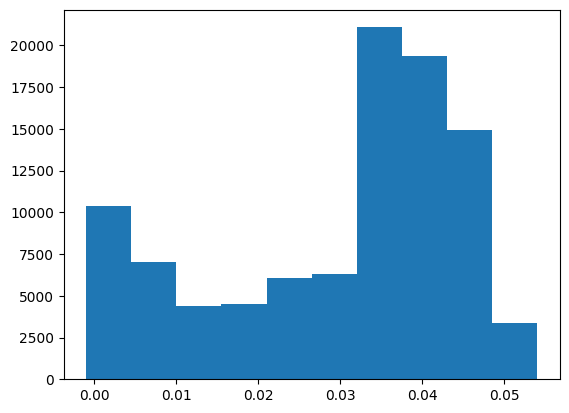

In [123]:
df_72310017['delta'] = df_ats.t.diff().dt.total_seconds()
#df_72310017.info()
#print(df_72310017.N.min())
#print(df_72310017.delta.mean())
plt.hist(df_72310017.delta)
#display(df_72310017)

# Combined

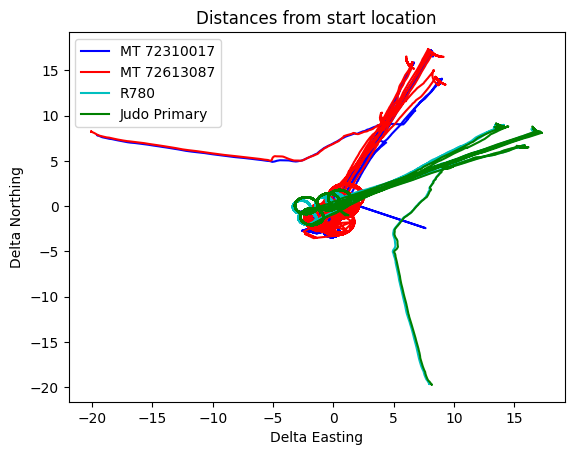

In [227]:
plt.plot(df_72310017.dE, df_72310017.dN, 'b-')
plt.plot(df_72613087.dE, df_72613087.dN, 'r-')
plt.plot(df_r780.dE, df_r780.dN, 'c-')
plt.plot(df_judo.dE, df_judo.dN, 'g-')

plt.xlabel('Delta Easting')
plt.ylabel('Delta Northing')
plt.title('Distances from start location')
plt.legend(['MT 72310017', 'MT 72613087', 'R780', 'Judo Primary'])

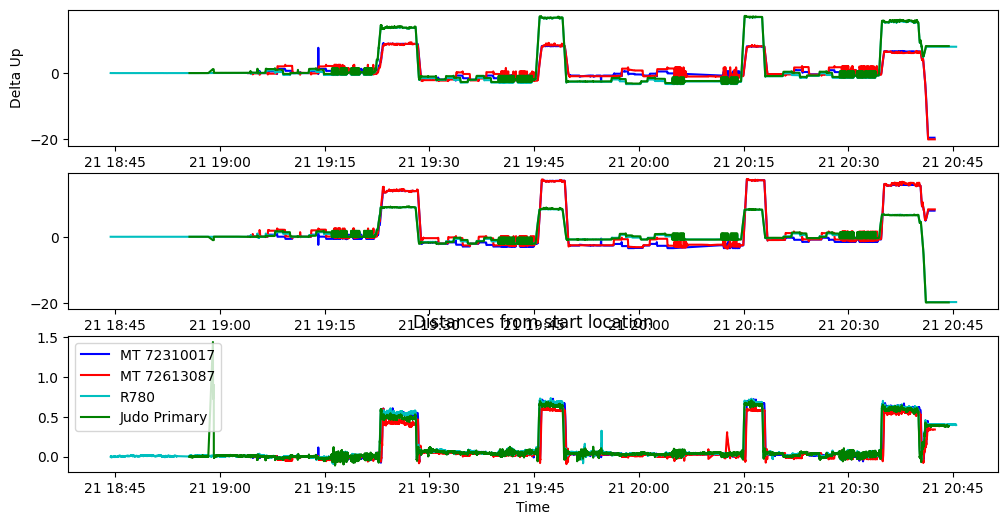

In [230]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 6))

ax0.plot(df_72310017.t, df_72310017.dE, 'b-')
ax0.plot(df_72613087.t, df_72613087.dE, 'r-')
ax0.plot(df_r780.time_utc, df_r780.dE, 'c-')
ax0.plot(df_judo.time_utc, df_judo.dE, 'g-')
plt.title('Distances from start location')
ax0.set_ylabel('Delta Easting')

ax1.plot(df_72310017.t, df_72310017.dN, 'b-')
ax1.plot(df_72613087.t, df_72613087.dN, 'r-')
ax1.plot(df_r780.time_utc, df_r780.dN, 'c-')
ax1.plot(df_judo.time_utc, df_judo.dN, 'g-')
ax0.set_ylabel('Delta Northing')

ax2.plot(df_72310017.t, df_72310017.dH, 'b-')
ax2.plot(df_72613087.t, df_72613087.dH, 'r-')
ax2.plot(df_r780.time_utc, df_r780.dH, 'c-')
ax2.plot(df_judo.time_utc, df_judo.dH, 'g-')
ax0.set_ylabel('Delta Up')

plt.xlabel('Time')

plt.legend(['MT 72310017', 'MT 72613087', 'R780', 'Judo Primary'])